# Geodata train

## Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import json
import time
import re
from tqdm.notebook import tqdm
import random
import scipy.stats
import json
import pickle
import matplotlib.pyplot as plt
import statsmodels.stats.proportion as proportion

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder
import xgboost as xgb

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import geopandas as gpd
%matplotlib inline

In [3]:
# Сброс ограничений на количество выводимых рядов
#pd.set_option('display.max_rows', None)

# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

# Сброс ограничений на количество символов в записи
#pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('../data/2015-street-tree-census-tree-data.csv')

## Анализ данных

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 45 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   tree_id           683788 non-null  int64  
 1   block_id          683788 non-null  int64  
 2   created_at        683788 non-null  object 
 3   tree_dbh          683788 non-null  int64  
 4   stump_diam        683788 non-null  int64  
 5   curb_loc          683788 non-null  object 
 6   status            683788 non-null  object 
 7   health            652172 non-null  object 
 8   spc_latin         652169 non-null  object 
 9   spc_common        652169 non-null  object 
 10  steward           652173 non-null  object 
 11  guards            652172 non-null  object 
 12  sidewalk          652172 non-null  object 
 13  user_type         683788 non-null  object 
 14  problems          652124 non-null  object 
 15  root_stone        683788 non-null  object 
 16  root_grate        68

In [6]:
df.head(3)

tree_id  block_id               created_at  tree_dbh  stump_diam curb_loc  \
0   180683    348711  2015-08-27T00:00:00.000         3           0   OnCurb   
1   200540    315986  2015-09-03T00:00:00.000        21           0   OnCurb   
2   204026    218365  2015-09-05T00:00:00.000         3           0   OnCurb   

  status health                           spc_latin   spc_common steward  \
0  Alive   Fair                         Acer rubrum    red maple    None   
1  Alive   Fair                   Quercus palustris      pin oak    None   
2  Alive   Good  Gleditsia triacanthos var. inermis  honeylocust    1or2   

  guards  sidewalk         user_type problems root_stone root_grate  \
0   None  NoDamage  TreesCount Staff     None         No         No   
1   None    Damage  TreesCount Staff   Stones        Yes         No   
2   None    Damage         Volunteer     None         No         No   

  root_other trunk_wire trnk_light trnk_other brch_light brch_shoe brch_other  \
0         No         No         No         No         No        No         No   
1         No         No         No         No         No        No         No   
2         No         No         No         No         No        No         No   

             address  postcode      zip_city  community board  borocode  \
0  108-005 70 AVENUE     11375  Forest Hills              406         4   
1   147-074 7 AVENUE     11357    Whitestone              407         4   
2  390 MORGAN AVENUE     11211      Brooklyn              301         3   

    borough  cncldist  st_assem  st_senate   nta           nta_name  boro_ct  \
0    Queens        29        28         16  QN17       Forest Hills  4073900   
1    Queens        19        27         11  QN49         Whitestone  4097300   
2  Brooklyn        34        50         18  BK90  East Williamsburg  3044900   

      state   latitude  longitude         x_sp         y_sp  council district  \
0  New York  40.723092 -73.844215  1027431.148  202756.7687              29.0   
1  New York  40.794111 -73.818679  1034455.701  228644.8374              19.0   
2  New York  40.717581 -73.936608  1001822.831  200716.8913              34.0   

   census tract        bin           bbl  
0         739.0  4052307.0  4.022210e+09  
1         973.0  4101931.0  4.044750e+09  
2         449.0  3338310.0  3.028870e+09

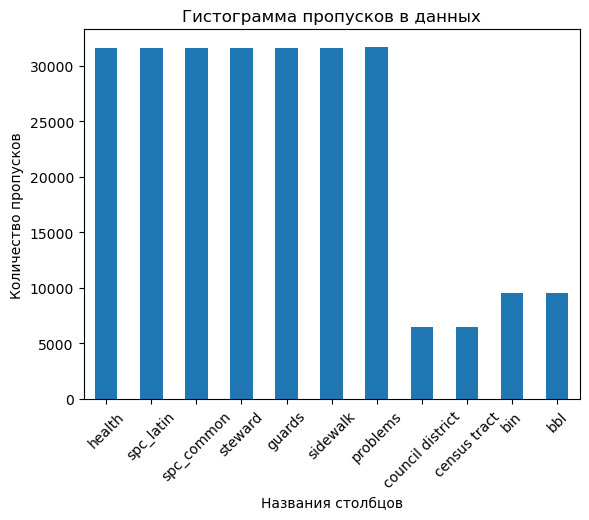

In [7]:
count_null = df.isnull().sum()
count_null[count_null>0].plot(kind='bar')
plt.title('Гистограмма пропусков в данных')
plt.xlabel('Названия столбцов')
plt.ylabel('Количество пропусков')
plt.xticks(rotation=45)
plt.show()

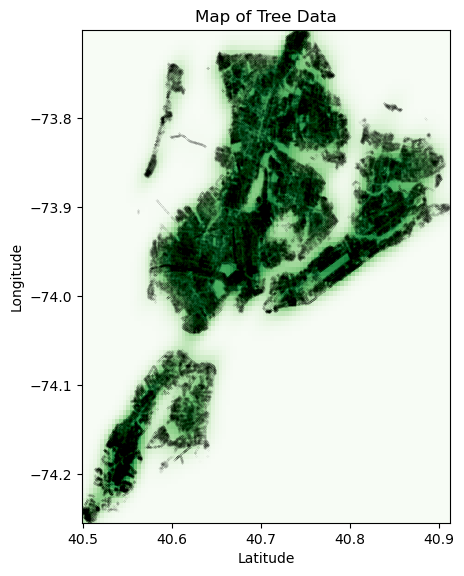

In [8]:
df2 = df[['latitude', 'longitude']]
latitudes = df2.latitude.tolist()
longitudes = df2.longitude.tolist()
xmin, xmax = min(latitudes), max(latitudes)
ymin, ymax = min(longitudes), max(longitudes)
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([latitudes, longitudes])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)
fig = plt.figure()
fig.set_size_inches(30, fig.get_figwidth(), forward=True)
ax = fig.add_subplot(111)
ax.imshow(np.rot90(Z), cmap=plt.cm.Greens,extent=[xmin, xmax, ymin, ymax])
ax.plot(latitudes, longitudes, 'k.', markersize=0.02)
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_title("Map of Tree Data")
plt.show()